In [290]:
from qiskit import QuantumCircuit, QuantumRegister
import os, sys
import numpy
import random
from tqdm import tqdm
import rustworkx
import json
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, partial_trace

if not '../' in sys.path:
    sys.path.insert(1, '../')

In [291]:
from helperfunctions.circuitgraphfunctions import get_computation_graph, get_uncomp_circuit
from helperfunctions.uncompfunctions import add_uncomputation, exhaustive_uncomputation_adding, greedy_uncomputation_full, greedy_uncomputation_partial
from helperfunctions.graphhelper import edge_attr, edge_matcher,node_attr,node_matcher, breakdown_qubit
from helperfunctions.measurecircuit import get_statevector, get_probability_from_statevector, zero_ancillas_in_statevector
from helperfunctions.constants import UncompType
from helperfunctions.randomcircuit import random_quantum_circuit_large_with_params

from rustworkx.visualization import graphviz_draw

In [292]:
def qubit_shifting_circuit_with_no_uncomp():
    circuit = QuantumCircuit(QuantumRegister(3,'cq'), QuantumRegister(3,'aq'))
    for i in range(3):
        circuit.h(i)
        circuit.cx(i,i+3)
    for i in range(3):
        circuit.cx(i+3,i)

    circuit.cx(3,1)
    circuit.cx(4,2)
    circuit.cx(5,0)

    for i in range(3):
        circuit.h(i)

    return circuit, 3,3,9
    
def qubit_shifting_circuit_with_some_uncomp():
    circuit = QuantumCircuit(QuantumRegister(3,'cq'), QuantumRegister(3,'aq'))
    for i in range(3):
        circuit.h(i)
        circuit.cx(i,i+3)
    # for i in range(3):
    #     circuit.cx(i+3,i)

    circuit.cx(3,1)
    circuit.cx(4,2)
    circuit.cx(5,0)

    circuit.cx(1,0)
    circuit.cx(2,1)
    circuit.cx(5,2)

    for i in range(3):
        circuit.h(i)
    
    return circuit, 3,3,9
    
def static_circuit_1(theta=0.25):
    circuit = QuantumCircuit(QuantumRegister(3, name='cq'), QuantumRegister(3, name='aq'))
    
    for i in range(3):
        circuit.ry(theta*numpy.pi, i)
        # circuit.h(i)
        # circuit.rx(theta*numpy.pi, i)
        # circuit.ry(theta*numpy.pi, i)
        # circuit.rx(theta*numpy.pi/2, i)
    
    circuit.cx(0,3)
    circuit.cx(1,3)
    
    circuit.cz(3,0)
    
    circuit.cx(0,5)
    
    circuit.cx(4,3)
    circuit.cx(3,4)
    
    circuit.cx(1,5)
    circuit.cx(2,3)
    
    circuit.cx(3,4)
    circuit.cx(4,3)
    circuit.cx(5,2)

    for i in range(3):
        circuit.h(i)


    return circuit, 3, 3, 11

def static_circuit_2(theta=0):
    
    circuit = QuantumCircuit(QuantumRegister(5, name='cq'), QuantumRegister(5, name='aq'))
    
    for i in range(5):
        # circuit.rx(theta*numpy.pi, i)
        circuit.h(i)
        if i < 4:
            circuit.ry(theta*numpy.pi*(i+1)/10, i)

    circuit.barrier()

    circuit.ccx(0,1,5)
    circuit.ccx(2,3,7)
    circuit.cx(4,6)
    
    circuit.barrier()

    circuit.ccx(5,6,8)
    circuit.ccx(6,7,9)

    circuit.barrier()

    circuit.ccx(0,2,8)
    circuit.ccx(1,3,9)

    circuit.cz(5,4)
    circuit.cz(7,4)
    
    circuit.barrier()
    
    circuit.ccx(8,9,6)
    circuit.cz(6,4)

    circuit.barrier()
    
    for i in range(5):
        circuit.h(i)

    return circuit, 5, 5, 11

Adding Nodes for Circuit: 100%|██████████| 30/30 [00:00<00:00, 84676.39it/s]


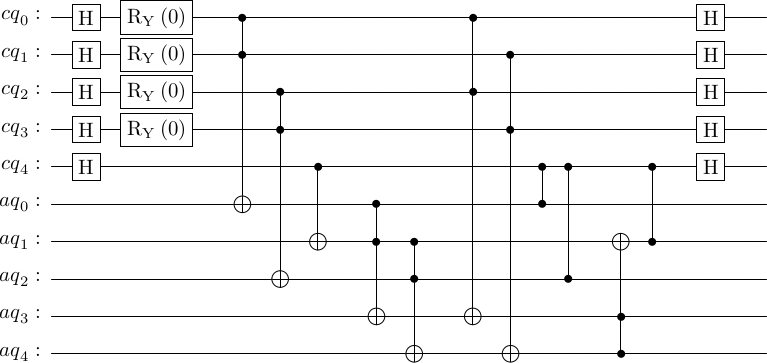

In [293]:
# Change these values for different number of input(q), ancilla(a) and gates(g)
# q = 4
# a = 7 
# g = 40
comp_circuit, q, a, g = static_circuit_2()
# comp_circuit.draw('latex')
ancillas_list = [breakdown_qubit(q)['label'] for q in comp_circuit.qubits][-a:]
# ancillas = breakdown_qubit
comp_graph = get_computation_graph(comp_circuit, ancillas_list)
comp_circuit.draw('latex', plot_barriers=False)

Checking Out Exhaustive Uncomp for All Ancillas: 32it [00:00, 897.35it/s]


('aq0', 'aq2')


Building uncomp circuit from circuit graph: 100%|██████████| 42/42 [00:00<00:00, 99638.44it/s]


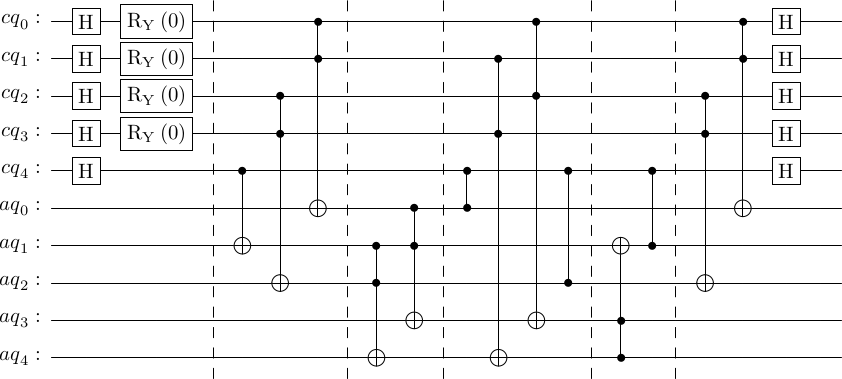

In [294]:
largest_ancilla = exhaustive_uncomputation_adding(comp_graph, ancillas_list)
print(largest_ancilla)
exhaustive_cg, cycle = add_uncomputation(comp_graph, largest_ancilla)
exhaustive_circuit = get_uncomp_circuit(exhaustive_cg)
exhaustive_circuit.draw('latex')

Iterating over all cycles in graph:   5%|▍         | 4888/100000 [00:00<00:00, 392340.60it/s]


aq4 16981


Iterating over all cycles in graph:   0%|          | 43/100000 [00:00<00:00, 340292.59it/s]


aq1 78


Iterating over all cycles in graph:   0%|          | 3/100000 [00:00<00:02, 48582.67it/s]


aq3 6


Building uncomp circuit from circuit graph: 100%|██████████| 42/42 [00:00<00:00, 93108.23it/s]


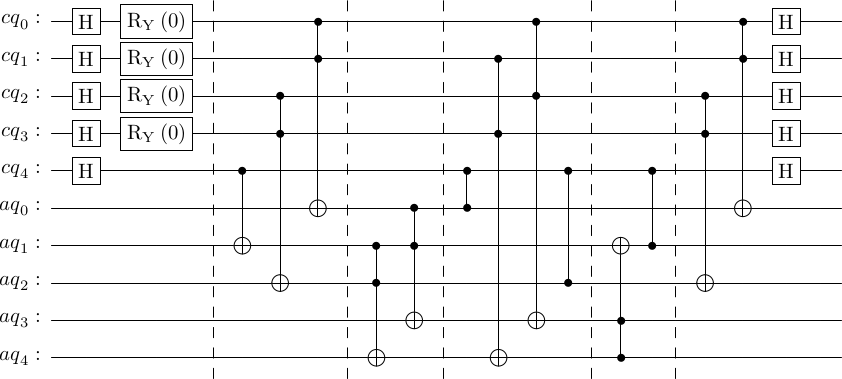

In [295]:
greedy_full_cg = greedy_uncomputation_full(comp_graph, ancillas_list)
greedy_full_circuit = get_uncomp_circuit(greedy_full_cg)
greedy_full_circuit.draw('latex')

Iterating over all cycles:   5%|▍         | 4888/100000 [00:00<00:00, 282288.38it/s]


aq4 16981


Iterating over all cycles:   0%|          | 70/100000 [00:00<00:00, 293015.25it/s]


aq1 124


Building uncomp circuit from circuit graph: 100%|██████████| 46/46 [00:00<00:00, 92536.20it/s]


['aq0', 'aq2', 'aq3']


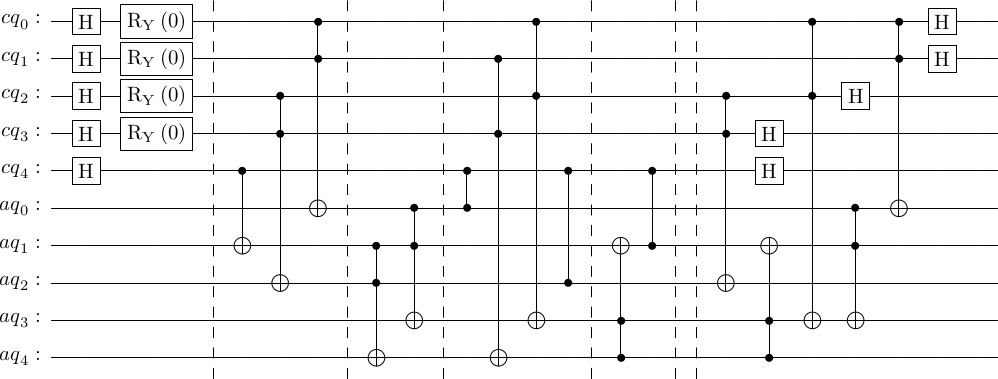

In [296]:
greedy_part_cg, al = greedy_uncomputation_partial(comp_graph, ancillas_list, return_uncomputed_ancillas=True)
greedy_part_circuit = get_uncomp_circuit(greedy_part_cg)
print(al)
greedy_part_circuit.draw('latex')

In [297]:
desired_sv = zero_ancillas_in_statevector(Statevector(comp_circuit), a)


In [298]:
from helperfunctions.measurecircuit import get_computation_qubit_probabilty


no_uncomp = get_computation_qubit_probabilty(comp_circuit, range(q))
desired = get_computation_qubit_probabilty(desired_sv,range(q))
exhaustive = get_computation_qubit_probabilty(exhaustive_circuit,range(q))
greedy_full = get_computation_qubit_probabilty(greedy_full_circuit,range(q))
greedy_part = get_computation_qubit_probabilty(greedy_part_circuit,range(q))

In [299]:
print(len(desired_sv))
print(len(desired))

1024
32


In [300]:
print(desired)

[7.69230769e-02 3.93846154e-13 3.93846154e-13 1.92307692e-02
 3.93846154e-13 3.93846154e-13 3.93846154e-13 3.93846154e-13
 3.93846154e-13 3.93846154e-13 3.93846154e-13 1.92307692e-02
 1.92307692e-02 1.92307692e-02 3.93846154e-13 3.93846154e-13
 6.92307692e-01 3.93846154e-13 1.92307692e-02 3.93846154e-13
 1.92307692e-02 1.92307692e-02 3.93846154e-13 3.93846154e-13
 3.93846154e-13 7.69230769e-02 1.92307692e-02 3.93846154e-13
 3.93846154e-13 3.93846154e-13 3.93846154e-13 3.93846154e-13]


In [301]:
plot_x = [bin(i)[2:] for i in range(len(no_uncomp))]
plt_dict = {'no_uncomp':[], 'desired':[], 'exhaustive':[], 'greedy_full':[], 'greedy_part':[]}
for i in range(len(plot_x)):
    plt_dict['no_uncomp'].append(no_uncomp[i])
    plt_dict['desired'].append(desired[i])
    plt_dict['exhaustive'].append(exhaustive[i])
    plt_dict['greedy_full'].append(greedy_full[i])
    plt_dict['greedy_part'].append(greedy_part[i])

In [302]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0

In [303]:
import pandas as pd

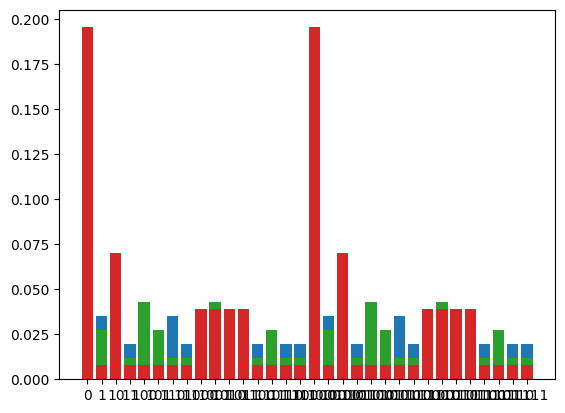

In [304]:
plt.bar(x=plot_x, height=plt_dict['no_uncomp'])
plt.bar(x=plot_x, height=plt_dict['exhaustive'])
plt.bar(x=plot_x, height=plt_dict['greedy_full'])
plt.bar(x=plot_x, height=plt_dict['greedy_part'])

plt.show()

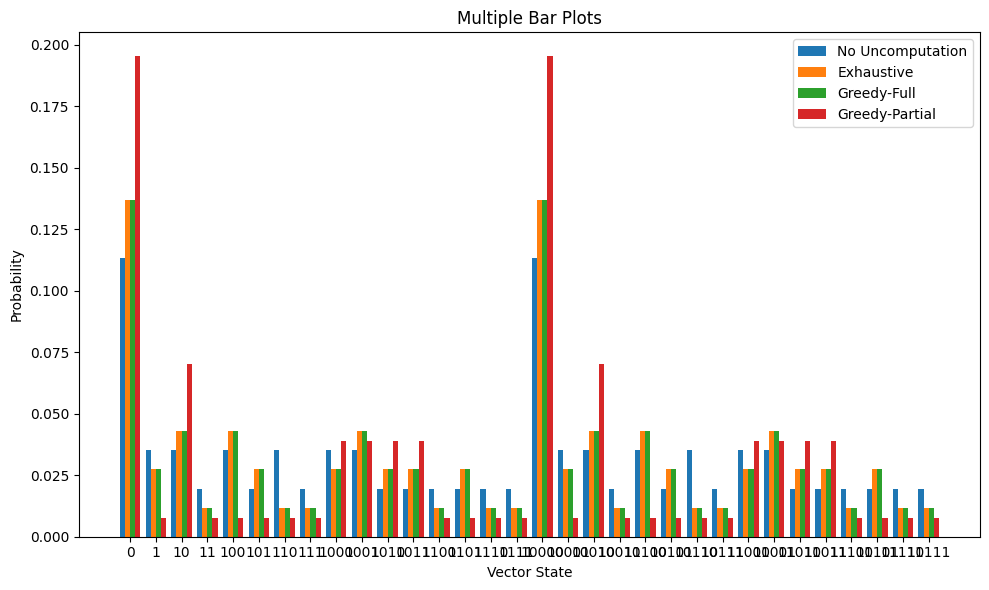

In [305]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - 1.5 * width, plt_dict['no_uncomp'], width, label='No Uncomputation')
rects2 = ax.bar(x - 0.5 * width, plt_dict['exhaustive'], width, label='Exhaustive')
rects3 = ax.bar(x + 0.5 * width, plt_dict['greedy_full'], width, label='Greedy-Full')
rects4 = ax.bar(x + 1.5 * width, plt_dict['greedy_part'], width, label='Greedy-Partial')

ax.set_xlabel('Vector State')
ax.set_ylabel('Probability')
ax.set_title('Multiple Bar Plots')
ax.set_xticks(x)
uni_I = ''
uni_K = ''

ax.set_xticklabels([f'{uni_I}{i}{uni_K}' for i in plot_x])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

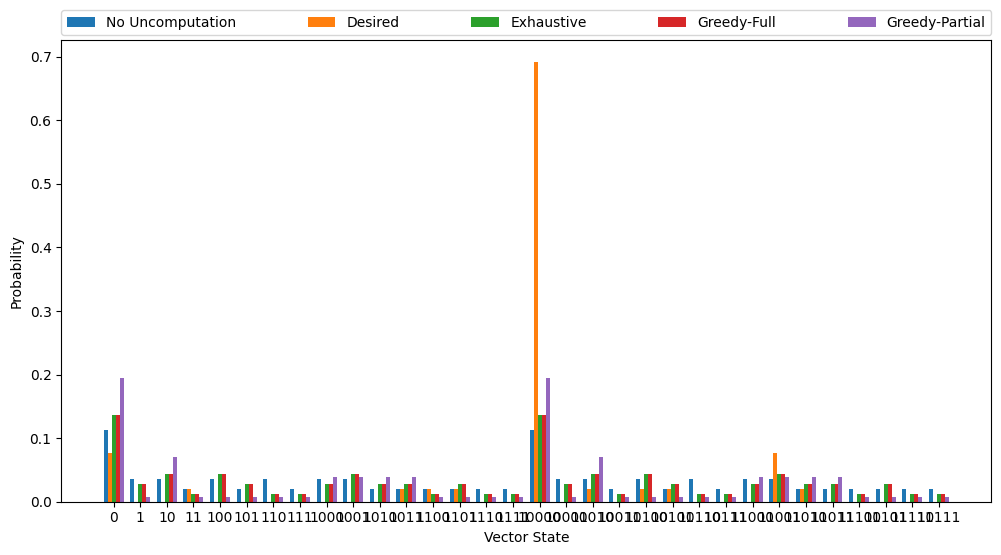

In [306]:
x = numpy.arange(len(plot_x))  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 2 * width, plt_dict['no_uncomp'], width, label='No Uncomputation')
rects1 = ax.bar(x - 1 * width, plt_dict['desired'], width, label='Desired')
rects2 = ax.bar(x, plt_dict['exhaustive'], width, label='Exhaustive')
rects3 = ax.bar(x + 1 * width, plt_dict['greedy_full'], width, label='Greedy-Full')
rects4 = ax.bar(x + 2 * width, plt_dict['greedy_part'], width, label='Greedy-Partial')

ax.set_xlabel('Vector State')
ax.set_ylabel('Probability')
# ax.set_title('Multiple Bar Plots')
ax.set_xticks(x)
uni_I = ''
uni_K = ''

ax.set_xticklabels([f'{uni_I}{i}{uni_K}' for i in plot_x])
ax.legend(bbox_to_anchor=(0, 1.01, 1, 0.2), loc='lower left',
          ncol=5, mode="expand", borderaxespad=0)

# Show the plot
# plt.tight_layout()
plt.show()